## This Notebook shows some functionalities of the package. For training, please use the train.py file!

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch 
import numpy as np 
from keypoint_detection.src.keypoint_utils import gaussian_heatmap, generate_keypoints_heatmap, get_keypoints_from_heatmap
from keypoint_detection import KeypointDetector
from keypoint_detection import BoxKeypointsDataModule, BoxKeypointsDataset, BoxDatasetPreloaded


In [4]:

wandb_logger = WandbLogger(project="test-project", entity="airo-box-manipulation")

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [6]:
torch.cuda.is_available()

False

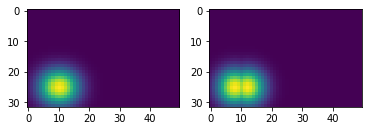

In [7]:
## Demonstration on why one should use max(.) instead of sum to combine the keypoints
# sum wil make 1 blob of 2 neighbouring keypoints
# furthermore it will also reduce the 
img = gaussian_heatmap((32,50),(8,25),torch.Tensor([4]))
img2 = gaussian_heatmap((32,50),(12,25),torch.Tensor([4]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img  +img2)
axarr[1].imshow(torch.max(img, img2))

In [8]:
IMAGE_DATASET_PATH = "/workspaces/box-manipulation/datasets/box_dataset2"
JSON_PATH = "/workspaces/box-manipulation/datasets/box_dataset2/dataset.json"

In [9]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


In [10]:
def show_heatmap_overlay(img, heatmap):
    """
    plot Tensors of heatmap and image on same figure 
    """
    fig, ax = plt.subplots()  #create figure and axes
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    ax.imshow(img, alpha= 0.9)
    ax.imshow(heatmap.numpy(), alpha = 0.2)
    plt.show()

In [11]:
## test caching influence

dataset = BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH)
preloaded_dataset = BoxDatasetPreloaded(JSON_PATH, IMAGE_DATASET_PATH)

preloading dataset images


100%|██████████| 250/250 [00:00<00:00, 502.64it/s]

dataset images preloaded


In [35]:
for i in range(len(dataset)):
    a = dataset[i]

In [41]:
for i in range(len(preloaded_dataset)):
    a = preloaded_dataset[i]


In [32]:
import sys
print(preloaded_dataset[0][0].dtype)
print(preloaded_dataset.preloaded_images[0].dtype)
# get torch tensor memory size -> 
print(f" torch image size = {sys.getsizeof(preloaded_dataset[0][0].storage())}")
print(f" expected torch image size = {256*256*3*4}") # float32!
# get numpy array memory size -> 
print(preloaded_dataset.preloaded_images[0].nbytes) # uint8
print(256*256*3*1)

torch.float32
uint8
 torch image size = 786488
 expected torch image size = 786432
196608
196608


In [42]:
## show output of batch

module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
#print(batch)
print(batch[0].shape)
print(batch[1].shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 4, 2])


Run model

In [ ]:
model = KeypointDetector(heatmap_sigma= 8)
dummy_input = torch.rand((1,3,180,180))

output = model(dummy_input)
print(output.shape)
print(model)

module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
imgs, corner_keypoints, flap_keypoints = batch 
print(imgs[0].shape[1:])
print(imgs.shape)

heatmaps = model.create_heatmap_batch(imgs[0].shape[1:],corner_keypoints)
flap_heatmaps = model.create_heatmap_batch(imgs[0].shape[1:], flap_keypoints)
print(heatmaps.shape)
show_heatmap_overlay(imgs[0],heatmaps[0])
show_heatmap_overlay(imgs[0],flap_heatmaps[0])

In [ ]:
pl.seed_everything(2021, workers = True) # deterministic run
model = KeypointDetector(detect_flap_keypoints=False)
module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
print(len(module.val_dataloader()))
print(len(module.train_dataloader()))
trainer = pl.Trainer(max_epochs = 1, logger=wandb_logger, gpus=0)


In [ ]:
trainer.fit(model, module)

In [ ]:
batch = next(iter(module.train_dataloader()))

imgs, corner_keypoints, flap_keypoints = batch 

with torch.no_grad():
    predictions = model(imgs)
    show_heatmap_overlay(imgs[0],predictions[0][0])